## Дипломный проект по курсу «Профессия Data Scientist: Анализ данных» ##


**Постановка задачи**

Компания «Мегафон» провела опрос своих клиентов, предложив им оценить уровень удовлетворённости качеством связи. По каждому клиенту, прошедшему опрос, были собраны технические показатели.

В ходе опроса, клиенты оценивали давали уровень удовлетворённости услугами по десятибалльной шкале (где 10 — это «отлично», а 1 — «ужасно»). Если клиент оценивал качество связи на 9 или 10 баллов, опрос заканчивался. Если клиент ставил оценку ниже 9, задавался второй вопрос — о причинах неудовлетворённости качеством связи с предоставленными пронумерованными вариантами ответа. Ответ можно было дать в свободном формате или перечислить номера ответов через запятую. 

Как и любой бизнес, компания «Мегафон» хочет повысить удовлетворённость своих клиентов качеством услуг. Это важная задача для удержания пользователей — как давних, так и недавно привлечённых. Ведь затраты на маркетинг и продвижение не оправдаются, если клиент уйдёт из-за низкого качества связи. Однако в реальном мире ресурсы всегда ограничены, и в единицу времени технический отдел может решить конечное количество задач.
Чтобы делать это наиболее эффективно, **важно определить, какие технические показатели качества связи сильнее всего влияют на удовлетворённость клиентов, и в первую очередь направить ресурсы на работу с ними.**

In [361]:
import pandas as pd
import numpy as np
import random
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
import scipy as sp
from statsmodels.stats.proportion import proportion_confint
import warnings
warnings.filterwarnings('ignore')
pd.options.mode.chained_assignment = None  # default='warn
%matplotlib inline


In [362]:
data = pd.read_csv('megafon.csv')  

data.head(3)  # Cтруктура данных


,user_id,Q1,Q2,Total Traffic(MB),Downlink Throughput(Kbps),Uplink Throughput(Kbps),Downlink TCP Retransmission Rate(%),Video Streaming Download Throughput(Kbps),Video Streaming xKB Start Delay(ms),Web Page Download Throughput(Kbps),Web Average TCP RTT(ms)
0,1,5,NaN,775.48846,360.13,86.56,3.93,1859.15,2309,1007.82,83
1,2,5,4,861.96324,3023.54,411.18,1.27,667.47,2080,255.36,425
2,3,1,4,261.11860,790.96,34.20,1.79,1079.60,6367,535.85,485


**Структура полученных данных**

**user_id** — идентификатор абонента;

**Q1 — ответ на первый вопрос** В ходе опроса компания «Мегафон» предложила своим клиентам оценить уровень удовлетворённости качеством связи по десятибалльной шкале (где 10 — это «отлично», а 1 — «ужасно»). Если клиент оценивал качество связи на 9 или 10 баллов, опрос заканчивался;

**Q2 - ответ на второй вопрос** ; Если клиент ставил оценку ниже 9, задавался второй вопрос — о причинах неудовлетворённости качеством связи с предоставленными пронумерованными вариантами ответа. Ответ можно было дать в свободном формате или перечислить номера ответов через запятую:
1. Недозвоны, обрывы при звонках
2. Время ожидания гудков при звонке
3. Плохое качество связи в зданиях, тц и т.д.
4. Медленный мобильный интернет
5. Медленная загрузка видео
6. Затрудняюсь ответить
7. Свой вариант

**Total Traffic(MB)** — объем трафика передачи данных, насколько активно абонент использует мобильный интернет;

**Downlink Throughput(Kbps)** — средняя скорость «к абоненту», считается по всему трафику передачи данных;

**Uplink Throughput(Kbps)**— средняя скорость «от абонента», считается по всему трафику передачи данных;

**Downlink TCP Retransmission Rate(%)** — частота переотправок пакетов «к абоненту», чем выше, тем хуже. Если в канале возникает ошибка, пакет переотправляется. Снижается полезная скорость;

**Video Streaming Download Throughput(Kbps)** — скорость загрузки потокового видео, чем выше, тем лучше — меньше прерываний и лучше качество картинки;

**Video Streaming xKB Start Delay(ms)** — задержка старта воспроизведения видео, cколько времени пройдёт между нажатием на кнопку Play и началом воспроизведения видео. Чем меньше это время, тем быстрее начинается воспроизведение;

**Web Page Download Throughput(Kbps)** — скорость загрузки web-страниц через браузер, чем выше, тем лучше;

**Web Average TCP RTT(ms)** — пинг при просмотре web-страниц, чем меньше, тем лучше — быстрее загружаются web-страницы.

Первый технический показатель представлен как сумма за период в одну неделю перед участием в опросе. Остальные технические показатели отображают среднее значение по данному признаку за период в одну неделю перед участием в опросе.

### Предобработка данных ###

In [363]:
data.info() # Непустые значения в колонках


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3112 entries, 0 to 3111
Data columns (total 11 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   user_id                                    3112 non-null   int64  
 1   Q1                                         3110 non-null   object 
 2   Q2                                         1315 non-null   object 
 3   Total Traffic(MB)                          3112 non-null   float64
 4   Downlink Throughput(Kbps)                  3112 non-null   float64
 5   Uplink Throughput(Kbps)                    3112 non-null   float64
 6   Downlink TCP Retransmission Rate(%)        3112 non-null   float64
 7   Video Streaming Download Throughput(Kbps)  3112 non-null   float64
 8   Video Streaming xKB Start Delay(ms)        3112 non-null   int64  
 9   Web Page Download Throughput(Kbps)         3112 non-null   float64
 10  Web Average TCP RTT(ms) 

**Работа с переменной Q1 - ответ на первый вопрос, возможные значения 1-10**

In [364]:
data['Q1'].value_counts()  # Имеющиеся значения и их количество


10                                                                      846
1                                                                       532
3                                                                       325
8                                                                       291
9                                                                       238
5                                                                       234
7                                                                       200
2                                                                       168
4                                                                       123
6                                                                       101
0                                                                        10
Нет                                                                       2
Да                                                                        2
1, 3        

In [365]:
data['user_id'] = data['user_id'].astype(str)  # Удалим ошибочные и пропущенные значения с ответом на первый вопрос
data['Q1'] = data['Q1'].astype('str')
data['Q1'] = [elem if elem in ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
                    else np.NaN for elem in data['Q1']]
data.dropna(subset=['Q1'], inplace=True)

data['Q1'].value_counts() # Количество значений после удаления ошибок


10    846
1     532
3     325
8     291
9     238
5     234
7     200
2     168
4     123
6     101
Name: Q1, dtype: int64

**Разделим абонентов на группы и создадим метки группы для всех абонентов - A: оценка (9-10), B: оценка (5-8), C: оценка (1-4)**

In [366]:
data['Group'] = data['Q1']

data['Group'] = ['A' if elem in ['9', '10'] else 'B' if elem
                    in ['5', '6', '7', '8'] else 'C' for elem in data['Group']]

data['Group'].value_counts()  # Количество абонентов по группам


C    1148
A    1084
B     826
Name: Group, dtype: int64

In [367]:
#  Изменим порядок колонок в датасете

cols = ['user_id', 'Group', 'Q1', 'Q2', 'Total Traffic(MB)',
        'Downlink Throughput(Kbps)', 'Uplink Throughput(Kbps)',
        'Video Streaming Download Throughput(Kbps)', 'Web Page Download Throughput(Kbps)',
        'Downlink TCP Retransmission Rate(%)', 'Video Streaming xKB Start Delay(ms)',
        'Web Average TCP RTT(ms)']
data = data[cols]

data_q1 = data.copy()

data.head(1)


,user_id,Group,Q1,Q2,Total Traffic(MB),Downlink Throughput(Kbps),Uplink Throughput(Kbps),Video Streaming Download Throughput(Kbps),Web Page Download Throughput(Kbps),Downlink TCP Retransmission Rate(%),Video Streaming xKB Start Delay(ms),Web Average TCP RTT(ms)
0,1,B,5,NaN,775.48846,360.13,86.56,1859.15,1007.82,3.93,2309,83


In [368]:
# Т.к. отсутствующие значения остались только в колонке Q2, проставим ответ 6 (затрудняюсь ответить) для пустых значений

data.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3058 entries, 0 to 3111
Data columns (total 12 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   user_id                                    3058 non-null   object 
 1   Group                                      3058 non-null   object 
 2   Q1                                         3058 non-null   object 
 3   Q2                                         1315 non-null   object 
 4   Total Traffic(MB)                          3058 non-null   float64
 5   Downlink Throughput(Kbps)                  3058 non-null   float64
 6   Uplink Throughput(Kbps)                    3058 non-null   float64
 7   Video Streaming Download Throughput(Kbps)  3058 non-null   float64
 8   Web Page Download Throughput(Kbps)         3058 non-null   float64
 9   Downlink TCP Retransmission Rate(%)        3058 non-null   float64
 10  Video Streaming xKB Star

In [369]:
data[data['Group'] != 'A'] = data[data['Group'] != 'A'].fillna('6')


In [370]:
data[(data['Q1'] == '9') | (data['Q1'] == '10')][['Q2']].shape[0]  # Проверим количество строк группы A


1084

In [371]:
data[(data['Q1'] == '9') | (data['Q1'] == '10')][['Q2']].isna().sum()[0] # Проверим пустые значения группы A на Q2 - совпадает


1084

#### Построение средних и медиан для показателей, разделенных по группам A, B, C

In [372]:
Q1_mean_1 = data.groupby(['Group'])[['user_id']].count()
Q1_mean_1.columns = ['user_id, count']
Q1_mean_2 = data.groupby(['Group']).agg('mean') \
                       .sort_values(by='Group').round(2)
Q1_mean = pd.concat([Q1_mean_1, Q1_mean_2], axis=1)

Q1_median_1 = data.groupby(['Group'])[['user_id']].count()
Q1_median_1.columns = ['user_id, count']
Q1_median_2 = data.groupby(['Group']).agg('median') \
                         .sort_values(by='Group').round(2)

Q1_median = pd.concat([Q1_median_1, Q1_median_2], axis=1)

Q1_mean  # Средние значения для числовых показателей

,"user_id, count",Total Traffic(MB),Downlink Throughput(Kbps),Uplink Throughput(Kbps),Video Streaming Download Throughput(Kbps),Web Page Download Throughput(Kbps),Downlink TCP Retransmission Rate(%),Video Streaming xKB Start Delay(ms),Web Average TCP RTT(ms)
Group,,,,,,,,,
A,1084,401.18,2506.02,182.43,6303.19,2290.30,1.65,1919.19,167.38
B,826,414.00,2238.94,177.01,6029.35,2111.86,1.73,2103.70,177.15
C,1148,404.14,1926.94,154.87,4983.45,1901.85,2.08,2300.69,232.29


In [373]:
Q1_median

,"user_id, count",Total Traffic(MB),Downlink Throughput(Kbps),Uplink Throughput(Kbps),Video Streaming Download Throughput(Kbps),Web Page Download Throughput(Kbps),Downlink TCP Retransmission Rate(%),Video Streaming xKB Start Delay(ms),Web Average TCP RTT(ms)
Group,,,,,,,,,
A,1084,353.94,1641.36,124.15,4934.91,1848.65,1.19,1552.0,105.0
B,826,381.78,1430.30,122.88,4697.72,1686.64,1.28,1673.5,114.5
C,1148,360.47,1160.53,112.54,3721.00,1515.93,1.46,1795.0,137.0


Показатели: Total Traffic - из опрошенных мобильный интернет активнее всего используется пользователями группы 'B';

Downlink Throughput,Uplink Throughput, Video Streaming Download Throughput, Web Page Download Throughput - наибольшие показатели скорости загрузки у пользователей группы 'A', наименьшие у группы 'C';

Downlink TCP Retransmission Rate(частота переотправок пакетов «к абоненту»), Video Streaming xKB Start Delay(задержка старта воспроизведения видео), Web Average TCP RTT(пинг при просмотре web-страниц) - наименьшие (наилучшие) показатели у пользователей группы 'A', наибольшие (наихудшие) - у группы 'C';

В целом, основываясь на рассмотренных выборках, имеется предположение, что разница в показателях пользователей группы 'A' и группы 'B' различаются меньше, чем разница в показателях группы 'B' и 'C'.

#### Рассмотрим показатели долей пользователей группы А и B, C

In [374]:
data_quest1 = data.copy()

data_quest1[['user_id']].duplicated().sum()  # Количество повторяющихся пользователей


0

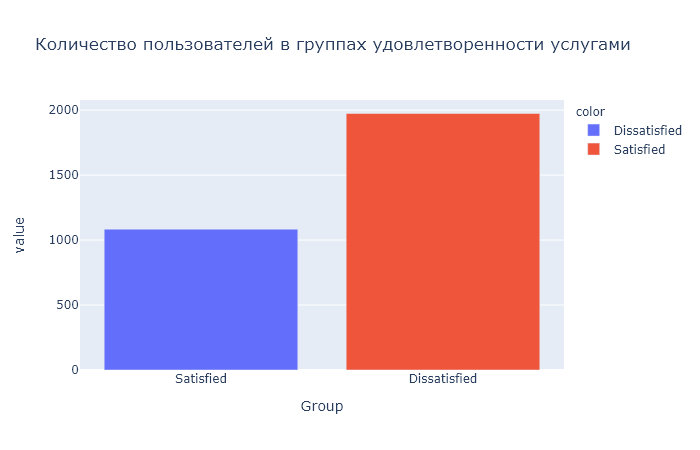

In [375]:
data_quest1['Group'] = ['Satisfied' if elem == 'A' else 'Dissatisfied' for elem in data_quest1['Group']]

fig = px.bar(data_quest1.groupby(['Group'])[['user_id']].count().sort_values(by='user_id'),
       color=data_quest1.groupby(['Group'])[['user_id']].count().index,
        title='Количество пользователей в группах удовлетворенности услугами', width=800)
fig.show('png')


In [376]:
print('Недовлетворенных пользователей: {}, удовлетворенных пользователей: {}, всего пользователей в опросе: {}' \
     .format(data_quest1.query('Group == "Dissatisfied"').shape[0], data_quest1.query('Group == "Satisfied"').shape[0], 
            data_quest1.shape[0]))


Недовлетворенных пользователей: 1974, удовлетворенных пользователей: 1084, всего пользователей в опросе: 3058


**Работа с переменной Q2 - ответ на первый вопрос, возможные значения 1-7, или несколько ответов**

In [377]:
data['Q2'].value_counts()  # Возможные значения и их количество 


6                   669
3                   190
4                   170
1                   168
1, 3                121
3, 4                 85
1, 3, 4              76
7                    64
1, 4                 56
3, 4, 5              45
1, 2, 3              44
1, 3, 4, 5           40
4, 5                 30
1, 2, 3, 4, 5        27
1, 4, 5              27
1, 2                 22
1, 2, 3, 4           18
2, 3                 12
1, 2, 4              11
2                    11
2, 3, 4              11
5                     9
3, 5                  8
1, 5                  7
2, 4                  4
1, 2, 3, 5            4
1, 2, 4, 5            4
3, 4, 5, 7            3
2, 3, 4, 5            3
1, 4, 7               3
1, 2, 5               3
1, 3, 5               3
1, 3, 4, 5, 7         2
3, 7                  2
3, 4, 7               2
2, 4, 5               2
1, 3, 7               2
1, 2, 3, 4, 5, 6      2
1, 3, 4, 7            2
0                     1
0, 3                  1
0, 1, 7         

In [378]:
# Для наблюдений с несколькими вариантами, уберем пробелы, переведем в списки и разобьем на отдельные наблюдения.
# Значения остальных атрибутов для таких наблюдений остаются неизменными.

data['Q2'] = data['Q2'].str.replace(" ", "").str.split(',')
data = data.explode('Q2')


In [379]:
data['Q2'] = [elem if elem in ['1', '2', '3', '4', '5', '6', '7', np.NaN]
                  else 'error' for elem in data['Q2']]
data = data[data['Q2'] != 'error']


In [380]:
data['Q2'].value_counts() # Финальное количество вариантов ответа на Q2


3    705
6    672
1    647
4    625
5    221
2    184
7     86
Name: Q2, dtype: int64

In [381]:
# Заполним пропуски в Q2 для групп B и C нейтральным ответов

data[data['Group'] != 'A'] = data[data['Group'] != 'A'].fillna('6')
data = data.reset_index(drop=True)

data_q2 = data.copy()


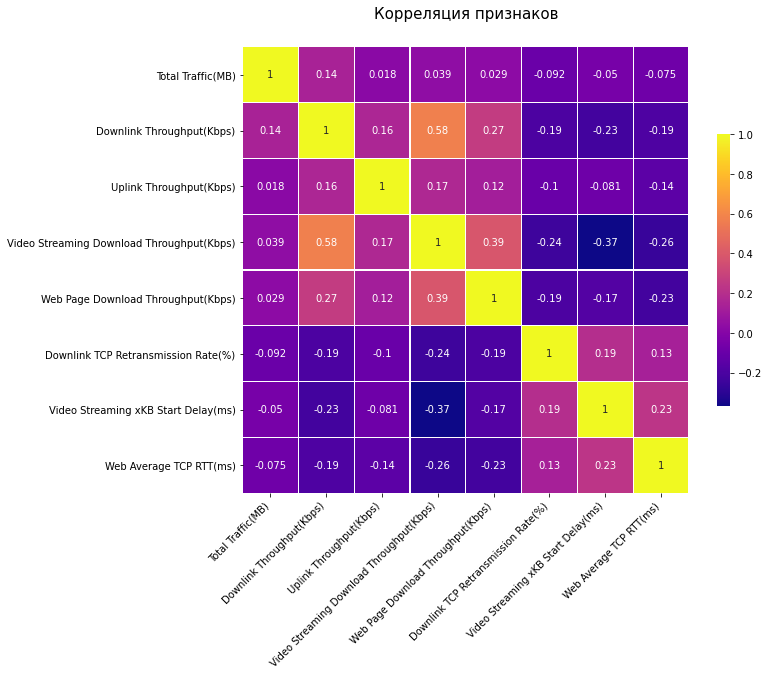

In [382]:
# Корреляция признаков

plt.figure(figsize=(10,10))
plt.title('Корреляция признаков', y=1.05, size=15)
sns.heatmap(data_q1.corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=plt.cm.plasma, linecolor='white', annot=True, cbar_kws={"shrink": 0.5})
plt.xticks(rotation=45, ha='right')
plt.show()

Сильная корреляция между рассматриваемыми величинами отсутсвует, наибольшее значение коэффициента ***0.58*** между **Video Streaming Download Throughput** и **Downlink Throughput**, ***-0.37*** между **Video Streaming Download Throughput** и **Video Streaming xKB Start Delay**, ***0.39*** между **Video Streaming Download Throughput** и **Web Page Download Throughput**.

**Рассмотрим меры центральной тенденции - среднее и медиану для групп пользователей разделенных по ответу на второй вопрос:**

1.Недозвоны, обрывы при звонках  
2.Время ожидания гудков при звонке  
3.Плохое качество связи в зданиях, тц и т.д.  
4.Медленный мобильный интернет  
5.Медленная загрузка видео  
6.Затрудняюсь ответить  
7.Свой вариант  

In [383]:
# Построение массивов кол-во наблюдений + значения показателей

Q2_mean_1 = data.groupby(['Q2'])[['user_id']].count()
Q2_mean_1.columns = ['user_id, count']
Q2_mean_2 = data.groupby(['Q2']).agg('mean') \
                   .sort_values(by='Q2').round(2)

Q2_mean = pd.concat([Q2_mean_1, Q2_mean_2], axis=1) 

Q2_median_1 = data.groupby(['Q2'])[['user_id']].count()
Q2_median_1.columns = ['user_id, count']
Q2_median_2 = data.groupby(['Q2']).agg('median').sort_values(by='Q2').round(2)

Q2_median = pd.concat([Q2_median_1, Q2_median_2], axis=1)

Q2_mean  # Средние для числовых показателей


,"user_id, count",Total Traffic(MB),Downlink Throughput(Kbps),Uplink Throughput(Kbps),Video Streaming Download Throughput(Kbps),Web Page Download Throughput(Kbps),Downlink TCP Retransmission Rate(%),Video Streaming xKB Start Delay(ms),Web Average TCP RTT(ms)
Q2,,,,,,,,,
1,647,399.99,2141.58,166.94,5721.10,2154.36,1.93,2328.09,203.95
2,184,391.25,1904.90,162.28,5594.17,1841.58,2.09,2159.28,230.65
3,705,404.72,1968.72,158.40,5242.17,2013.59,1.94,2226.49,207.72
4,625,415.25,1770.23,149.95,4486.02,1823.05,2.13,2451.40,262.86
5,221,421.64,1543.25,134.22,3942.15,1528.09,2.38,2307.68,278.14
6,672,409.41,2071.82,166.60,5425.01,1913.98,1.95,2096.69,192.93
7,86,403.86,2078.11,180.67,5527.49,1996.53,2.21,2202.47,217.00


In [384]:
Q2_median  # Медианные значения для числовых показателей


,"user_id, count",Total Traffic(MB),Downlink Throughput(Kbps),Uplink Throughput(Kbps),Video Streaming Download Throughput(Kbps),Web Page Download Throughput(Kbps),Downlink TCP Retransmission Rate(%),Video Streaming xKB Start Delay(ms),Web Average TCP RTT(ms)
Q2,,,,,,,,,
1,647,359.80,1356.12,121.30,4303.92,1596.41,1.39,1733.0,129.0
2,184,360.69,1145.28,116.10,3684.69,1567.68,1.41,1740.0,133.0
3,705,357.45,1266.58,115.49,4056.44,1602.72,1.43,1732.0,127.0
4,625,380.39,1111.46,110.17,3363.09,1336.13,1.52,1863.0,144.0
5,221,404.08,965.71,99.00,2906.82,1306.30,1.52,1850.0,150.0
6,672,367.77,1257.63,114.82,4114.84,1615.05,1.34,1701.0,126.5
7,86,358.75,1371.53,125.74,4035.42,1503.00,1.51,1782.0,107.5


На первый взгляд - видимых различий не наблюдается, более детальные различия и гипотезы между данными группами далее будут проверены в ходе исследования

**Построение гистограмм распределений рассматривыемых признаков**

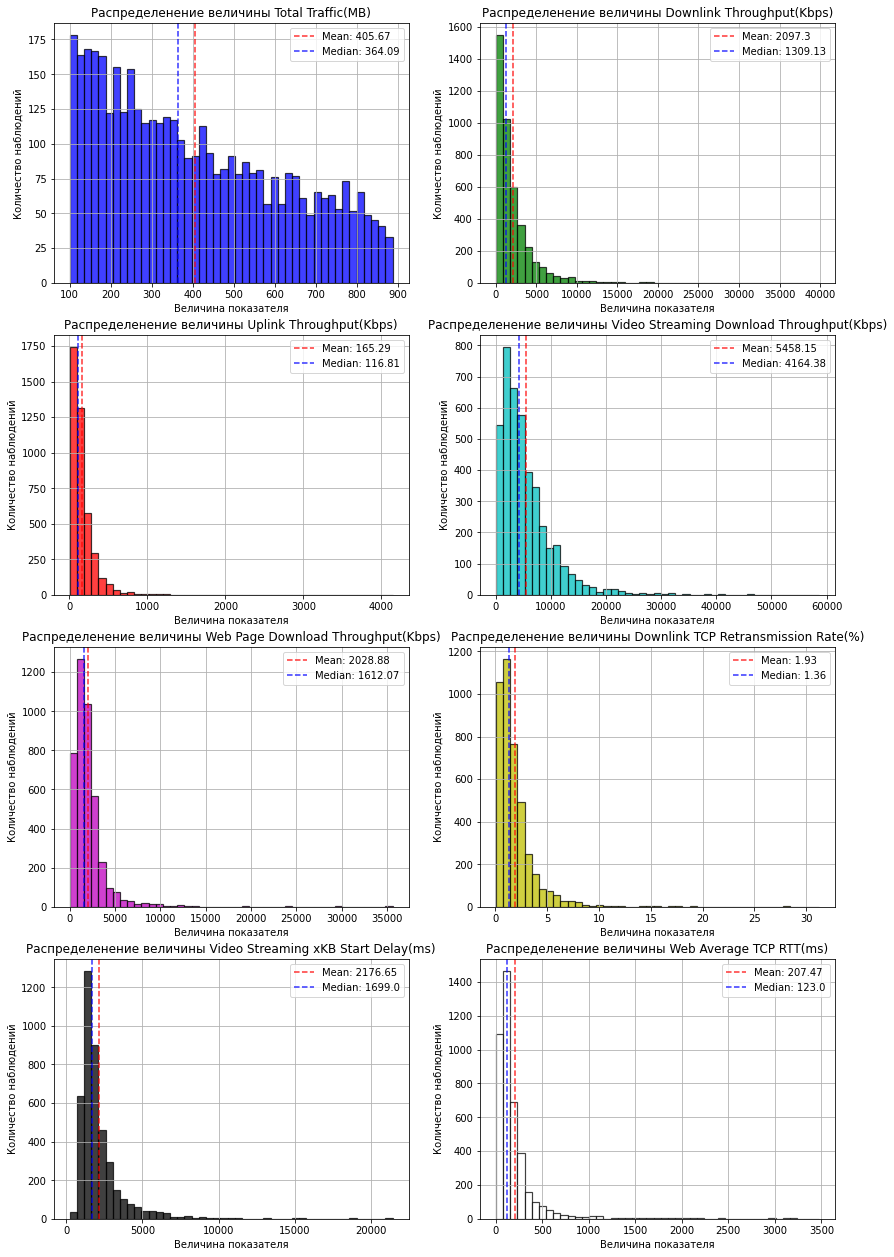

In [385]:
cols_par = ['Total Traffic(MB)',
        'Downlink Throughput(Kbps)', 'Uplink Throughput(Kbps)',
        'Video Streaming Download Throughput(Kbps)', 'Web Page Download Throughput(Kbps)',
        'Downlink TCP Retransmission Rate(%)', 'Video Streaming xKB Start Delay(ms)',
        'Web Average TCP RTT(ms)']

colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w'] # Список цветов граффиков

plt.figure(figsize=(14, 22)) 
for i, col in enumerate(cols_par): # Цикл для построения распределений числовых признаков
    plt.subplot(4, 2, i+1)
    plt.hist(data[col], bins=45, facecolor=colors[i], 
             alpha=0.75, edgecolor='black', linewidth=1.2)
    plt.axvline(data[col].mean(), color='red', alpha=0.8,
                linestyle='dashed', label='Mean: ' + str(round(data[col].mean(), 2)))
    plt.axvline(data[col].median(), color='blue', alpha=0.8, 
                linestyle='dashed', label='Median: ' + str(round(data[col].median(), 2)))
    plt.xlabel('Величина показателя')
    plt.ylabel('Количество наблюдений')
    plt.grid(True)
    plt.title('Распределенение величины '  + col)
    plt.legend(loc='upper right')
    plt.show
    

###### Распределения признаков сильно скошены вправо - попробуем применить логарифмирование и заново построить гистограммы

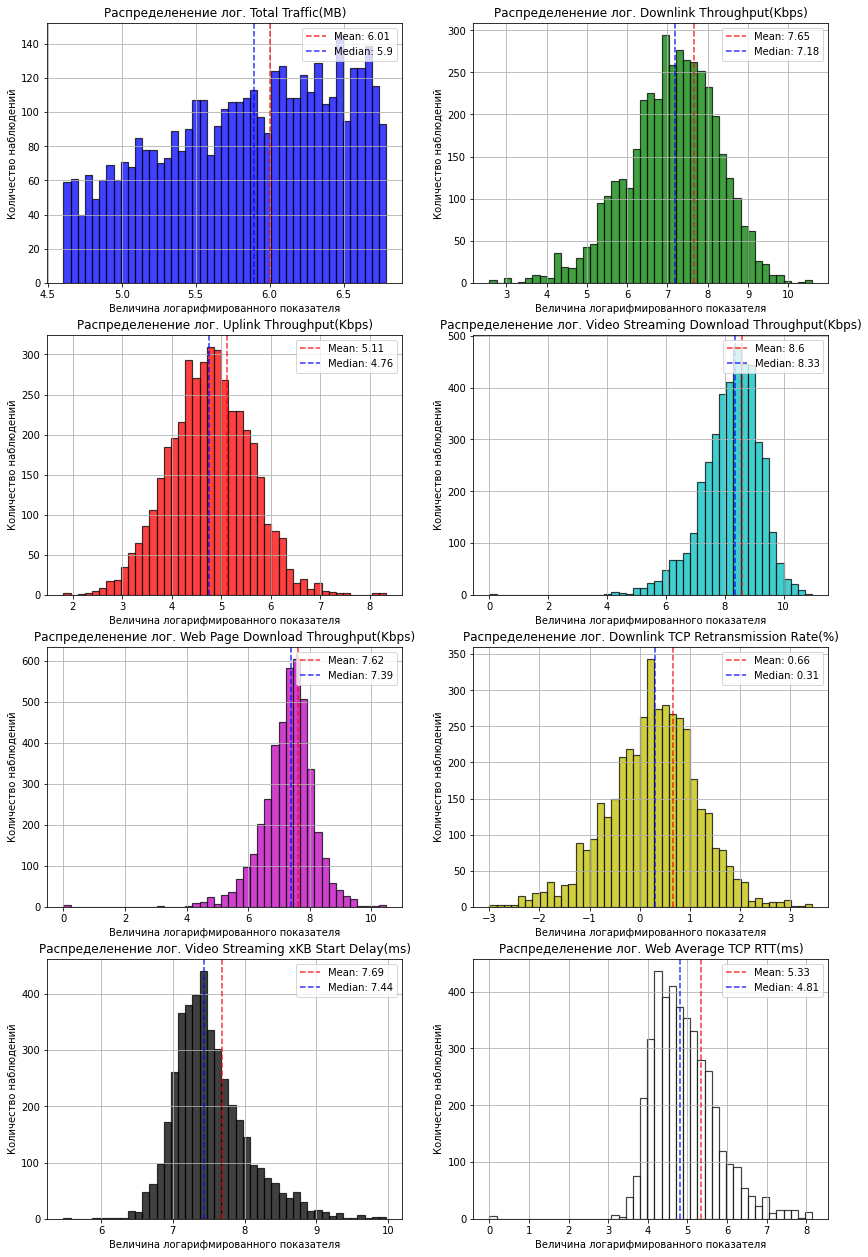

In [386]:
plt.figure(figsize=(14, 22)) 
for i, col in enumerate(cols_par): # Цикл для построения распределений числовых признаков
    plt.subplot(4, 2, i+1)
    plt.hist([np.log(i) if i != 0 else 0 for i in data[col]], bins=45, facecolor=colors[i], 
             alpha=0.75, edgecolor='black', linewidth=1.2)
    plt.axvline(np.log(data[col].mean()), color='red', alpha=0.8,
                linestyle='dashed', label='Mean: ' + str(round(np.log(data[col].mean()), 2)))
    plt.axvline(np.log(data[col].median()), color='blue', alpha=0.8, 
                linestyle='dashed', label='Median: ' + str(round(np.log(data[col].median()), 2)))
    plt.xlabel('Величина логарифмированного показателя')
    plt.ylabel('Количество наблюдений')
    plt.grid(True)
    plt.title('Распределенение лог. '  + col)
    plt.legend(loc='upper right')
    plt.show
    

Применив процедуру логарифмирование распределения признаков стали более симметричные и больше напоминать нормальные, что, возможно, позволить нам применить параметрические критерии, однако в этом случае интерпретация осложняется из-за этой же операции.

###### Note:

Каждому пользователю соответствует свой набор значений параметров, в нашем датасете не имеется больше 1 набора параметров для каждого пользователя. Некоторые пользователи ответили несколько вариантов на второй вопрос, но если мы будем рассматривать 2 группы разных ответов Q2, в тесты попадут пользователи, которые принадлежат обеим группам с одинаковым набором параметров, (напр. ответ на Q2 - 3 и ответ на Q2 - 4) нам придется исключить повторяющихся пользователей и терять из-за этого наблюдения.

Таких пользователей мы можем сравнить с пользователями, которые не попали в деление по Q2 - полностью удовлетворенными пользователями (ответ на Q1 - 9,10)

**В соответствии с дополнительной информацией, тесты по качеству голосовой связи фиксируют следующие параметры:**

- **Передачу данных: доля неуспешного TCP/IP соединения с сервером (HTTP IP-Service Access Failure Ratio);** доля неуспешных сессий по протоколу HTTP (HTTP Session Failure Ratio); **среднее значение скорости передачи данных к абоненту (HTTP DL Mean User Data Rate) в кбит/c;** продолжительность успешной сессии (HTTP Session Time) в мс.


### Проверим гипотезу о зависимости между ответами Q1 и Q2

Для рассматриваемых групп B (Q1:5-8) и C (Q1:1-4) будем рассматривать по очереди конверсию в каждый вопрос Q2 как '1', принимая ответы на другие вопросы как '0', относительно рассматриваемого вопроса Q2. В данном тесте будут проверены гипотезы, существует ли некая взаимосвязь в ответах на вопрос Q1 (1-8) и Q2, применяется критерий **Хи-квадрат**.

In [387]:
for k in range(1, 6):

    test1 = data_q2[(data_q2['Group'] == 'B') | (data_q2['Group'] == 'C')][['user_id', 'Group', 'Q2']]

    test1['Q2_p'] = [1 if i == str(k) else 0 for i in test1['Q2']]

    stat, p, dof, expected = st.chi2_contingency(pd.crosstab(test1.Group, test1.Q2_p))

    print('Вопрос Q2 = {}, p_value = {}'.format(k, np.round(p, 3)))

Вопрос Q2 = 1, p_value = 0.238
Вопрос Q2 = 2, p_value = 0.855
Вопрос Q2 = 3, p_value = 0.227
Вопрос Q2 = 4, p_value = 0.676
Вопрос Q2 = 5, p_value = 0.956


###### Ни в одном из рассматриваемых случаев мы не получили значимое p_value < 0.05, следовательно на наших данных мы не выявили значимых закономерностей между Q1 и Q2.

### Рассчитаем доверитальные интервалы для долей клиентов в группах

In [388]:
test2 = data_q1[data_q1['Group'].isin(['B', 'C'])][['user_id', 'Group']]
test2 = pd.get_dummies(test2, columns=['Group']) 
test2.head()

,user_id,Group_B,Group_C
0,1,1,0
1,2,1,0
2,3,0,1
3,4,1,0
4,5,0,1


In [389]:
norm_intA = proportion_confint(data_q1[data_q1['Group'] == 'A'].shape[0],
                               data_q1.user_id.nunique(), 
                                      method='normal')
print ('\nДоверительный интервал для доли пользователей группы A {}'.format(np.round(norm_intA, 4)))

norm_intB = proportion_confint(sum(test2['Group_B']), data_q1.user_id.nunique(), 
                                      method='normal')
print ('\nДоверительный интервал для доли пользователей группы B {}'.format(np.round(norm_intB, 4)))

norm_intC = proportion_confint(sum(test2['Group_C']), data_q1.user_id.nunique(), 
                                      method='normal')
print ('\nДоверительный интервал для доли пользователей группы C {}'.format(np.round(norm_intC, 4)))


Доверительный интервал для доли пользователей группы A [0.3375 0.3714]

Доверительный интервал для доли пользователей группы B [0.2544 0.2858]

Доверительный интервал для доли пользователей группы C [0.3582 0.3926]


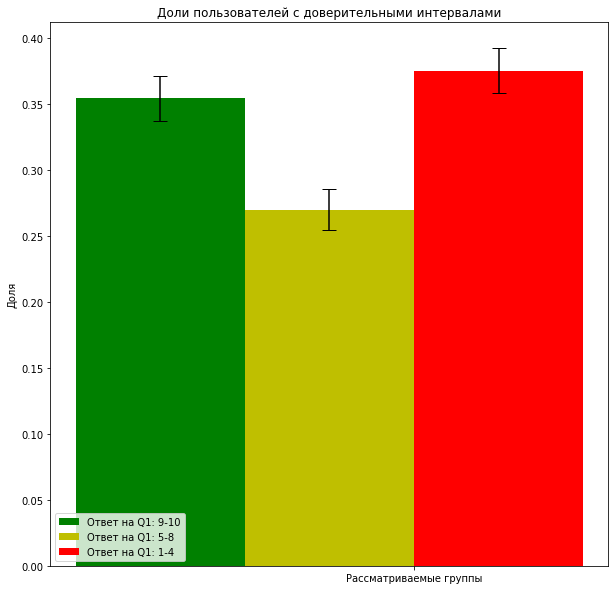

In [390]:
labels = ['Рассматриваемые группы']

agroup_prop = data_q1[data_q1['Group'] == 'A'].shape[0] / data_q1.user_id.nunique()
bgroup_prop = sum(test2['Group_B']) / data_q1.user_id.nunique()
cgroup_prop = sum(test2['Group_C']) / data_q1.user_id.nunique()

yer0 = (norm_intA[1] - norm_intA[0]) / 2
yer1 = (norm_intB[1] - norm_intB[0]) / 2
yer2 = (norm_intC[1] - norm_intC[0]) / 2

x = np.arange(len(labels))
width = 0.35  

fig, ax = plt.subplots()
ax.bar(x - width*1.5, agroup_prop, width, yerr=yer0, capsize=7,label='Ответ на Q1: 9-10', color='g')
ax.bar(x - width/2, bgroup_prop, width, yerr=yer1, capsize=7,label='Ответ на Q1: 5-8', color='y')
ax.bar(x + width/2, cgroup_prop, width, yerr=yer2, capsize=7, label='Ответ на Q1: 1-4', color='r')

ax.set_ylabel('Доля')
ax.set_title('Доли пользователей с доверительными интервалами')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc='lower left')
plt.gcf().set_size_inches(10, 10)
plt.show()

###### Исходя из построенных доверительных интервалов и визуализаций - можем сделать вывод об отсутствии явного перевеса в наполнении той или иной группы по количеству клиентов.

### Проверяем гипотезу относительно показателя Downlink TCP Retransmission Rate(%)*

*частота переотправок пакетов «к абоненту» (чем выше, тем хуже) между группами пользователей A и B



Группа A - пользователи, ответившие на второй вопрос (Q2) - 1,2,3: 1. Недозвоны, обрывы при звонках; 2. Время ожидания гудков при звонке; 3. Плохое качество связи в зданиях, тц и т.д
Группа B - пользователи, ответившие на первый вопрос (Q1) - 9, 10 (отличное качество связи)

Берем наши выборки, делаем по каждой из них бутстреп и проверяем с помощью построения доверительных интервалов, пересекаются ли они, а также генерируем распределение разницы средних.

In [391]:
# Группа A

data_dt_q2_a = data_q2[(data_q2['Q2'] == '1') | (data_q2['Q2'] == '2') | (data_q2['Q2'] == '3')] 

data_dt_q2_a = data_dt_q2_a.drop_duplicates(subset='user_id')  # Устранение повторяющихся пользователей внутри групп
data_dt_q2_a = data_dt_q2_a[['Downlink TCP Retransmission Rate(%)']]
data_dt_q2_a.head()


,Downlink TCP Retransmission Rate(%)
3,0.80
4,1.15
11,0.84
14,4.10
18,1.46


In [392]:
# Группа B
data_dt_q2_b = data_q2[data_q2['Group'] == 'A']
data_dt_q2_b = data_dt_q2_b.drop_duplicates(subset='user_id')  # Устранение повторяющихся пользователей внутри групп
data_dt_q2_b = data_dt_q2_b[['Downlink TCP Retransmission Rate(%)']]
data_dt_q2_b.head()


,Downlink TCP Retransmission Rate(%)
10,1.05
22,5.26
25,1.96
31,2.37
32,1.73


In [393]:
print('Average Downlink TCP Retransmission Rate(%) групп А и B: ({:.3f}; {:.3f})' \
      .format(data_dt_q2_a.mean()[0], data_dt_q2_b.mean()[0]))


Average Downlink TCP Retransmission Rate(%) групп А и B: (1.917; 1.653)


Построение гистограмм распределений рассматриваемых показателей

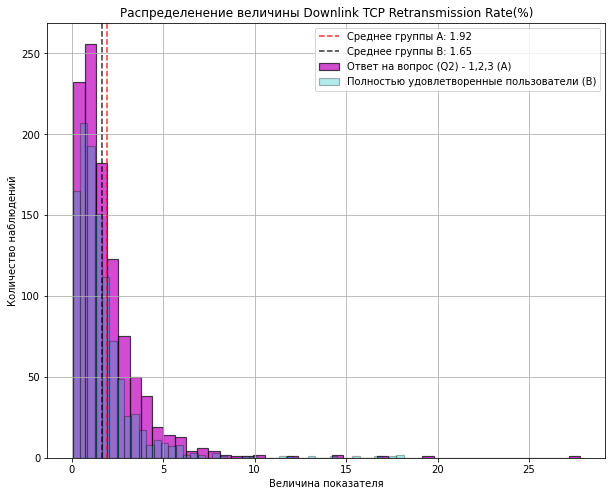

In [394]:
plt.figure(figsize=(10, 8))

plt.hist(data_dt_q2_a['Downlink TCP Retransmission Rate(%)'], bins=45, facecolor='m', 
             alpha=0.7, edgecolor='black', linewidth=1.2, label='Ответ на вопрос (Q2) - 1,2,3 (A)')
plt.hist(data_dt_q2_b['Downlink TCP Retransmission Rate(%)'], bins=45, facecolor='c', 
             alpha=0.3, edgecolor='black', linewidth=1.2, label='Полностью удовлетворенные пользователи (B)')
plt.axvline(data_dt_q2_a['Downlink TCP Retransmission Rate(%)'].mean(), 
            color='red', alpha=0.8,linestyle='dashed', 
            label='Среднее группы A: ' + str(round(data_dt_q2_a['Downlink TCP Retransmission Rate(%)'].mean(), 2)))

plt.axvline(data_dt_q2_b['Downlink TCP Retransmission Rate(%)'].mean(), color='black', alpha=0.8,
            linestyle='dashed', 
            label='Среднее группы B: ' + str(round(data_dt_q2_b['Downlink TCP Retransmission Rate(%)'].mean(), 2)))

plt.grid(True)
plt.xlabel('Величина показателя')
plt.ylabel('Количество наблюдений')
plt.title('Распределенение величины Downlink TCP Retransmission Rate(%)')
plt.legend(loc='upper right')
plt.show()
    

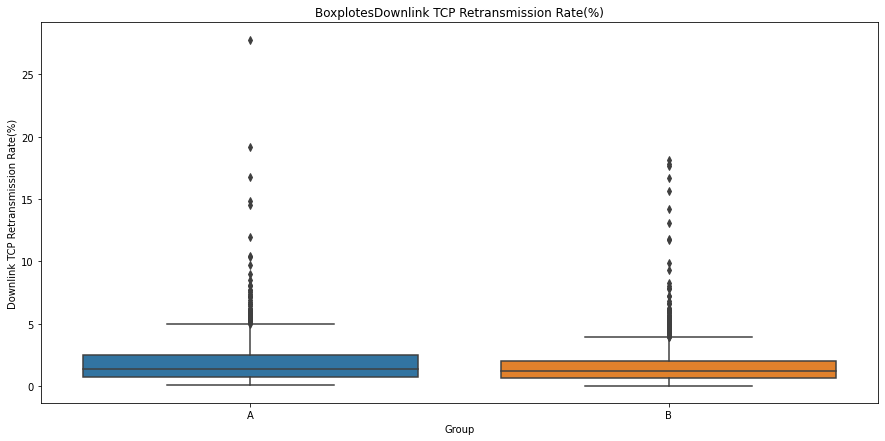

In [395]:
boxes = data_dt_q2_a[['Downlink TCP Retransmission Rate(%)']]
boxes['Group'] = 'A'
boxes = pd.concat([boxes, data_dt_q2_b[['Downlink TCP Retransmission Rate(%)']]]).fillna('B')

plt.figure(figsize=(15, 7))  # Боксплоты распределений контрольной и тестовой группы

sns.boxplot(x="Group", y="Downlink TCP Retransmission Rate(%)", data=boxes)
plt.title('BoxplotesDownlink TCP Retransmission Rate(%)')

plt.show()

**Рассматривается нулевая гипотеза о равенстве рассматриваемых средних Генеральных совокупностей, 
Альтернативная гипотеза - рассматриваемые средние не равны 
(Предполагается что среднее группы B < среднее группы A, т.к. больше - хуже)**

In [396]:
def bootstrap(x, y, n, bootstrap_conf_level=0.95): # Проверим гипотезу используя бутстрап
    
    boot_len = max([len(x), len(y)])
    boot_data = []
    
    for i in (range(n)): 
        samples_1 = x.sample(boot_len, replace = True).values
        samples_2 = y.sample(boot_len, replace = True).values
        boot_data.append(np.mean(samples_1-samples_2))
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = st.norm.cdf(x = 0, loc = np.mean(boot_data), scale = np.std(boot_data))
    p_2 = st.norm.cdf(x = 0, loc = -np.mean(boot_data), scale = np.std(boot_data))
    p_value = min(p_1, p_2) * 2
        
    plt.figure(figsize=(10, 7))
    plt.hist(pd_boot_data[0], bins=45, facecolor='royalblue', alpha=0.75, edgecolor='black', linewidth=1.2)
    plt.vlines(ci, 0, 650, linestyle='--', colors=['black'])
    plt.xlabel('mean_diff')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    print('2.5%-ый перцентиль:{:.2f}, 97.5%-ый перцентиль:{:.2f}, p-value: {:.3f}'
          .format(ci.values[0][0].astype('float64'), ci.values[1][0].astype('float64'), p_value))

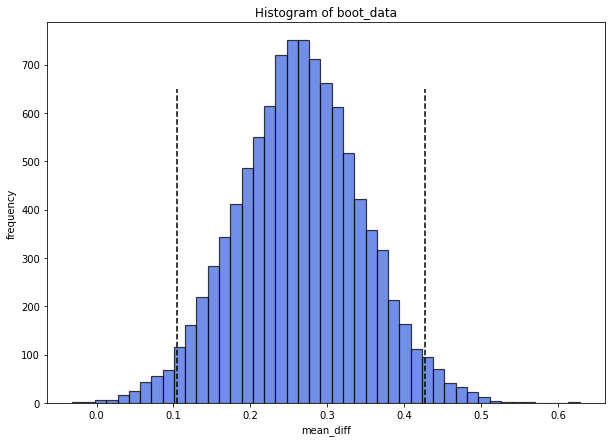

2.5%-ый перцентиль:0.10, 97.5%-ый перцентиль:0.43, p-value: 0.001


In [397]:
tcp_group_a = data_dt_q2_a['Downlink TCP Retransmission Rate(%)']
tcp_group_b = data_dt_q2_b['Downlink TCP Retransmission Rate(%)']
    
bootstrap(tcp_group_a, tcp_group_b, 10000)

P-value < 0.05 -> меньше чем уровень значимости = 0.05 -> нулевая гипотеза о равенстве средних отклоняется -> Разница есть 

**U-критерий Манна-Уитни**

Предположение по умолчанию или нулевая гипотеза заключается в том, что нет различий между распределениями выборок данных. Отказ от этой гипотезы позволяет предположить, что между образцами, вероятно, существует некоторое различие.

In [398]:
stat, p = st.mannwhitneyu(tcp_group_a, tcp_group_b)
print('P_value = %.3f' % (p))


P_value = 0.000


Согласно критерию Манна-Уитни - значимые различия в наблюдениях двух групп есть

**T-test для рассматриваемых групп**

In [399]:
# Проверка гомогенности дисперсий

print('P-value для теста Левина: {:.3f}'.format(st.levene(tcp_group_a, tcp_group_b)[1]))
             

P-value для теста Левина: 0.031


In [400]:
# Попробуем логарифмировать наблюдения

print('P-value для теста Левина: {:.3f}'.format(st.levene(np.log(tcp_group_a), np.log(tcp_group_b))[1]))

P-value для теста Левина: 0.793


In [401]:
print('P-value для t-теста: {:.3f}'.format(st.ttest_ind(np.log(tcp_group_a), np.log(tcp_group_b))[1]))

P-value для t-теста: 0.000


###### На основании произведенных расчетов и тестов можем сделать вывод, что показатель Downlink TCP Retransmission Rate(%) — частота переотправок пакетов «к абоненту», статистически различается (значимо больше у пользователей рассматриваемой группы A (Q2-1,2,3), чем у пользователей, довольных качеством).

### Проверяем гипотезу относительно показателя Downlink Throughput(Kbps)* 

*гипотеза относительно разницы средних показателя Downlink Throughput(Kbps) (средняя скорость «к абоненту») между группами пользователей A и B (возьмем совершенно разные аспекты связи, использующие один и тот же показатель)



Группа A - пользователи, ответившие на второй вопрос (Q2) - 3: Плохое качество связи в зданиях, тц и т.д.; Группа B - пользователи, ответившие на второй вопрос (Q2) - 4: Медленный мобильный интернет

In [402]:
# Группа A

data_dlink_a = data_q2[(data_q2['Q2'] == '3')].drop_duplicates(subset='user_id')[['Downlink Throughput(Kbps)']]
dlink_group_a = data_q2[(data_q2['Q2'] == '3')].drop_duplicates(subset='user_id')['Downlink Throughput(Kbps)']
data_dlink_a.head()


,Downlink Throughput(Kbps)
3,2590.97
5,731.61
12,1786.99
15,610.43
19,535.54


In [403]:
# Группа B
data_dlink_b = data_q2[(data_q2['Q2'] == '4')].drop_duplicates(subset='user_id')[['Downlink Throughput(Kbps)']]
dlink_group_b = data_q2[(data_q2['Q2'] == '4')].drop_duplicates(subset='user_id')['Downlink Throughput(Kbps)']
data_dlink_b.head()


,Downlink Throughput(Kbps)
1,3023.54
2,790.96
6,731.61
8,438.27
13,1786.99


In [404]:
print('Средние Downlink Throughput(Kbps) групп А и B: ({:.3f}; {:.3f})'\
      .format(data_dlink_a.mean()[0], data_dlink_b.mean()[0]))

Средние Downlink Throughput(Kbps) групп А и B: (1968.723; 1770.231)


Построение гистограмм распределений рассматриваемых показателей

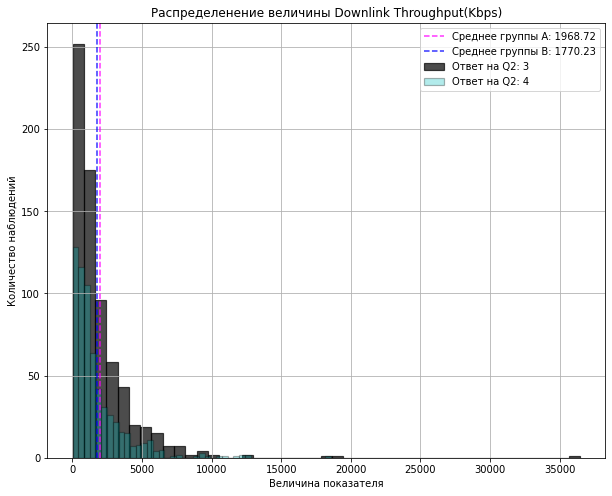

In [405]:
plt.figure(figsize=(10, 8))
plt.hist(data_dlink_a, bins=45, facecolor='black', 
             alpha=0.7, edgecolor='black', linewidth=1.2, label='Ответ на Q2: 3')
plt.hist(data_dlink_b, bins=45, facecolor='c', 
             alpha=0.3, edgecolor='black', linewidth=1.2, label='Ответ на Q2: 4')
plt.axvline(data_dlink_a.mean()[0], color='magenta', alpha=0.8,
            linestyle='dashed', 
            label='Среднее группы A: ' + str(round(data_dlink_a.mean()[0], 2)))

plt.axvline(data_dlink_b.mean()[0], color='blue', 
            alpha=0.8,linestyle='dashed', 
            label='Среднее группы B: ' + str(round(data_dlink_b.mean()[0], 2)))

plt.grid(True)
plt.xlabel('Величина показателя')
plt.ylabel('Количество наблюдений')
plt.title('Распределенение величины Downlink Throughput(Kbps)')
plt.legend(loc='upper right')
plt.show()
    

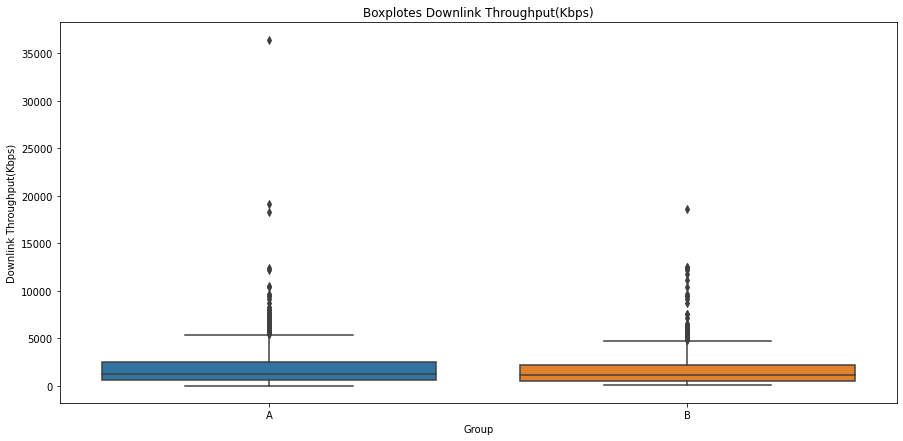

In [406]:
boxes = pd.DataFrame(data_dlink_a[:-1])
boxes['Group'] = 'A'
boxes = pd.concat([boxes,pd.DataFrame(data_dlink_b)]).fillna('B')

plt.figure(figsize=(15, 7))  # Боксплоты распределений контрольной и тестовой группы

sns.boxplot(x="Group", y="Downlink Throughput(Kbps)", data=boxes)
plt.title('Boxplotes Downlink Throughput(Kbps)')

plt.show()

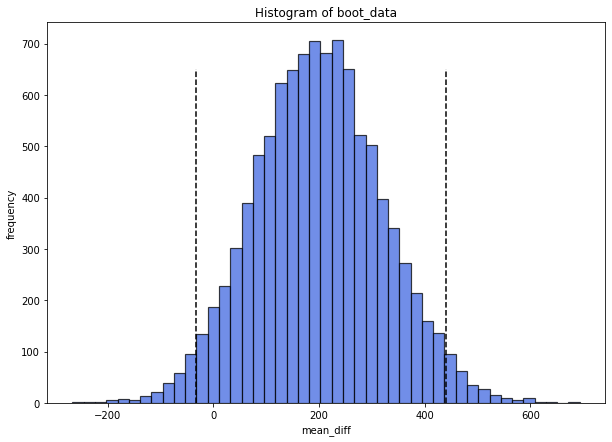

2.5%-ый перцентиль:-32.27, 97.5%-ый перцентиль:439.41, p-value: 0.098


In [407]:
 bootstrap(dlink_group_a, dlink_group_b, 10000)

Полученное P-value больше чем P-value = 0.05 при заданном уровне значимости -> нет оснований отклонить нулевую гипотезу о равенстве средних 

**U-критерий Манна-Уитни**

Предположение по умолчанию или нулевая гипотеза заключается в том, что нет различий между распределениями выборок данных. Отказ от этой гипотезы позволяет предположить, что между образцами, вероятно, существует некоторое различие.

In [408]:
stat, p = st.mannwhitneyu(dlink_group_a, dlink_group_b)
print('P_value = %.3f' % (p))


P_value = 0.025


Согласно критерию Манна-Уитни - значимые различия в наблюдениях двух групп есть

**T-test для рассматриваемых групп**

In [409]:
# Проверка гомогенности дисперсий

print('P-value для теста Левина: {:.3f}'.format(st.levene(dlink_group_a, dlink_group_b)[1]))
             

P-value для теста Левина: 0.233


In [410]:
print('P-value для t-теста: {:.3f}'.format(st.ttest_ind(dlink_group_a, dlink_group_b)[1]))

P-value для t-теста: 0.114


**На основании произведенных расчетов и тестов можем сделать вывод, что показатель Downlink Throughput(Kbps)(средняя скорость «к абоненту»), статистически не различается у пользователей ответивших на второй вопрос (Q2) - 3: Плохое качество связи в зданиях, тц и т.д. и пользователей, ответивших на второй вопрос (Q2) - 4: Медленный мобильный интернет**

**Следовательно, следует сравнить данный показатель между разными категориями пользователей - ответивших на вопрос Q2: 3,4 и пользователями ответивших на Q1: 9,10**

### Проверяем гипотезу относительно показателя Downlink Throughput(Kbps)* 

*гипотеза относительно разницы средних показателя Downlink Throughput(Kbps) (средняя скорость «к абоненту»)

Группа A - пользователи, ответившие на второй вопрос (Q2) - 3: Плохое качество связи в зданиях, тц и т.д., 4: Медленный мобильный интернет; Группа B - пользователи, ответившие на первый вопрос (Q1) - 9,10 (полностью удовлетворенные пользователи)

In [411]:
# Группа A

data_dlink_a_2 = data_q2[(data_q2['Q2'] == '3') | (data_q2['Q2'] == '4')].\
                drop_duplicates(subset='user_id')[['Downlink Throughput(Kbps)']]
dlink_group_a_2 = data_q2[(data_q2['Q2'] == '3') | (data_q2['Q2'] == '4')]\
                .drop_duplicates(subset='user_id')['Downlink Throughput(Kbps)']
data_dlink_a_2.head()


,Downlink Throughput(Kbps)
1,3023.54
2,790.96
3,2590.97
5,731.61
8,438.27


In [412]:
# Группа B

data_dlink_b_2 = data_q1[data_q1['Group'] == 'A'].\
                drop_duplicates(subset='user_id')[['Downlink Throughput(Kbps)']]
dlink_group_b_2 = data_q1[data_q1['Group'] == 'A'].\
                drop_duplicates(subset='user_id')['Downlink Throughput(Kbps)']
data_dlink_b_2.head()

,Downlink Throughput(Kbps)
7,3428.69
13,3004.18
15,1729.37
20,8115.33
21,2135.92


In [413]:
print('Средние Downlink Throughput(Kbps) групп А и B: ({:.3f}; {:.3f})'\
      .format(data_dlink_a_2.mean()[0], data_dlink_b_2.mean()[0]))

Средние Downlink Throughput(Kbps) групп А и B: (1924.916; 2506.017)


Построение гистограмм распределений рассматриваемых показателей

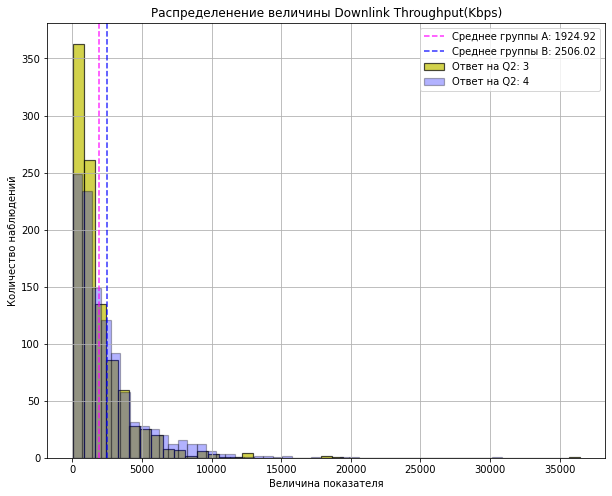

In [414]:
plt.figure(figsize=(10, 8))
plt.hist(data_dlink_a_2, bins=45, facecolor='y', 
             alpha=0.7, edgecolor='black', linewidth=1.2, label='Ответ на Q2: 3')
plt.hist(data_dlink_b_2, bins=45, facecolor='b', 
             alpha=0.3, edgecolor='black', linewidth=1.2, label='Ответ на Q2: 4')
plt.axvline(data_dlink_a_2.mean()[0], color='magenta', alpha=0.8,
            linestyle='dashed', 
            label='Среднее группы A: ' + str(round(data_dlink_a_2.mean()[0], 2)))

plt.axvline(data_dlink_b_2.mean()[0], color='blue', 
            alpha=0.8,linestyle='dashed', 
            label='Среднее группы B: ' + str(round(data_dlink_b_2.mean()[0], 2)))

plt.grid(True)
plt.xlabel('Величина показателя')
plt.ylabel('Количество наблюдений')
plt.title('Распределенение величины Downlink Throughput(Kbps)')
plt.legend(loc='upper right')
plt.show()
    

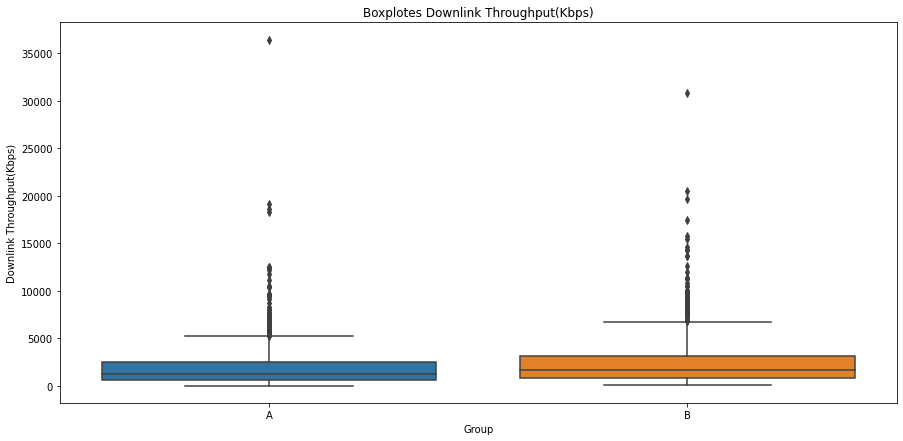

In [415]:
boxes = pd.DataFrame(data_dlink_a_2[:-1])
boxes['Group'] = 'A'
boxes = pd.concat([boxes,pd.DataFrame(data_dlink_b_2)]).fillna('B')

plt.figure(figsize=(15, 7))  # Боксплоты распределений контрольной и тестовой группы

sns.boxplot(x="Group", y="Downlink Throughput(Kbps)", data=boxes)
plt.title('Boxplotes Downlink Throughput(Kbps)')

plt.show()

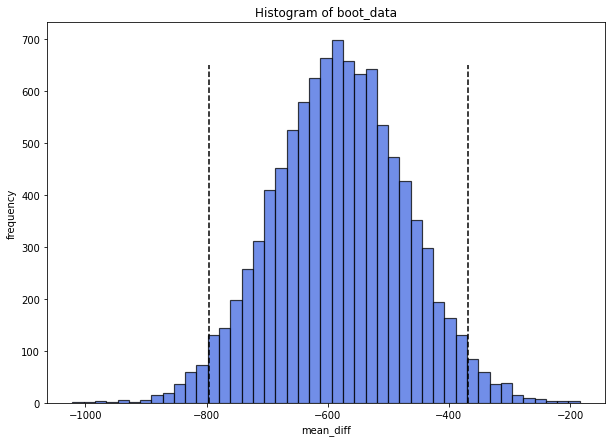

2.5%-ый перцентиль:-795.41, 97.5%-ый перцентиль:-368.46, p-value: 0.000


In [416]:
 bootstrap(dlink_group_a_2, dlink_group_b_2, 10000)

Полученное P-value больше чем P-value = 0.05 при заданном уровне значимости -> нет оснований отклонить нулевую гипотезу о равенстве средних 

**U-критерий Манна-Уитни**

Предположение по умолчанию или нулевая гипотеза заключается в том, что нет различий между распределениями выборок данных. Отказ от этой гипотезы позволяет предположить, что между образцами, вероятно, существует некоторое различие.

In [417]:
stat, p = st.mannwhitneyu(dlink_group_a_2, dlink_group_b_2)
print('P_value = %.3f' % (p))


P_value = 0.000


Согласно критерию Манна-Уитни - значимые различия в наблюдениях двух групп есть

**T-test для рассматриваемых групп**

In [418]:
# Проверка гомогенности дисперсий

print('P-value для теста Левина: {:.3f}'.format(st.levene(dlink_group_a_2, dlink_group_b_2)[1]))
             

P-value для теста Левина: 0.000


In [419]:
print('P-value для t-теста: {:.3f}'.format(st.ttest_ind(dlink_group_a_2, dlink_group_b_2)[1]))

P-value для t-теста: 0.000


**На основании произведенных расчетов и тестов можем сделать вывод, что показатель Downlink Throughput(Kbps)(средняя скорость «к абоненту»), статистически различается у ГС пользователей ответивших на второй вопрос (Q2) - 3,4 (3: Плохое качество связи в зданиях, тц и т.д. 4: Медленный мобильный интернет) и пользователей, ответивших на первый вопрос (Q1) - 9,10**

**Так как данный показатель, не отличается внутри групп пользователей ответивших на Q2 - 3 и 4, но статистически различается также между вышеуказанной обобщенной группой и пользователями, полностью довольными качеством связи (у пользователей данной группы значимо выше), можем сделать вывод, что данный показатель влияет на удовлетворённость клиентов и ресурсы на работу с ним направить нужно.**

### Итоги работы ###

**В ходе исследования были рассмотрены следующие вопросы и сделаны выводы:**  
- Зависимости взаимного влияния конкретной проблемы (Q2) на общую оценку клиента (Q1) не выявлено.  
- При разделении опрошенных пользователей по диапазонам оценки (Q1) на 3 группы A (оценка 9-10), B (5-8), C(1-4) наполнение клиентов по таким диапазонам статистически не доказано явного преимущества в группах A, B, C, картина близка к равномерной.  

Исследованы показатели качества связи Downlink TCP Retransmission Rate(%) и Downlink Throughput(Kbps):  
- На основании произведенных тестов можем сделать вывод, что Downlink TCP Retransmission Rate(%) — частота переотправок пакетов «к абоненту», статистически различается (значимо больше у пользователей рассматриваемой группы пролблем с голосовой связью (Q2-1,2,3), чем у пользователей, довольных качеством, больший показатель - хуже для качества.  
- Показатель Downlink Throughput(Kbps)(средняя скорость «к абоненту»), статистически не различается у пользователей ответивших на второй вопрос (Q2) - 3: Плохое качество связи в зданиях, тц и т.д. и пользователей, ответивших на второй вопрос (Q2) - 4: Медленный мобильный интернет  
- Тот же показатель статистически различается у пользователей ответивших на второй вопрос (Q2) - 3,4 (3: Плохое качество связи в зданиях, тц и т.д. 4: Медленный мобильный интернет) и пользователей, ответивших на первый вопрос (Q1) - 9, 10


### Дальнейшие исследования ###

Если мы хотим сделать вывод относительно того, на какие показатели направить работу технических специалистов, нужно сравнить разницу между релевантными техническими показателями для каждой проблемной группы (которые разделены по ответу на второй вопрос Q2) и группой пользователей, указавших ответ на первый вопрос - 9,10 (отличное качество связи и услуг), а также вычислить долю таких пользователей для каждой группы, имеющих названную проблему со связью, относительно всех пользователей.

Полученная разница показателей соотносится с полученной долей пользователей, и в соответствии с получившейся метрикой сравнения, мы можем сделать вывод, на какие технические показатели стоит направить работу технических специалистов.
